Borrowed parameter values and initial values from ADAM–SINDy paper (https://doi.org/10.48550/arXiv.2410.16528).

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0.5, 0.2, 1.0], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
omega = jnp.pi / 2
cos, sin = jnp.cos, jnp.sin


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    a, b, c = gs

    x, y, z = true

    return jnp.array(
        [
            a * sin(omega * z) + c * cos(omega * y),
            b * sin(omega * x) + a * cos(omega * z),
            c * sin(omega * y) + b * cos(omega * x),
        ]
    )


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    a, b, c = cs

    x, y, z = nudged

    return jnp.array(
        [
            a * sin(omega * z) + c * cos(omega * y),
            b * sin(omega * x) + a * cos(omega * z),
            c * sin(omega * y) + b * cos(omega * x),
        ]
    )


# System evolution parameters
gs = a, b, c = 2, 3, 1
c1, c2, c3 = gs
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
mu = 3

gs = jnp.array(gs)
cs0 = jnp.array([c1, c2, c3], dtype=float)

true0, assimilated0 = get_initial_values()

observed_mask = jnp.array([True, True, False])
system = System_ModelKnown(
    mu,
    gs,
    cs0,
    observed_mask,
    assimilated_ode,
    true_ode,
    use_unobserved_asymptotics=False,
)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)
optimizer = optax.adam(1e-2)
optimizer = optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 2000
t_begin_updates = 1000
t_relax = 2

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[:, system.observed_mask]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
    parameter_update_option=utils.ParameterUpdateOption.mean_gradient,
    t_begin_updates=t_begin_updates,
)

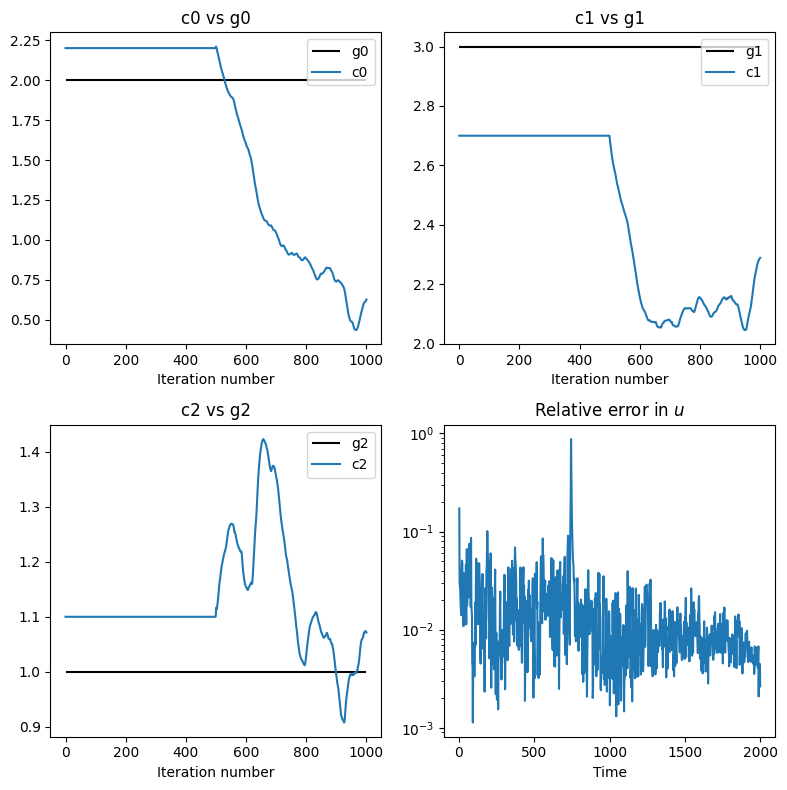

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
plt.show()

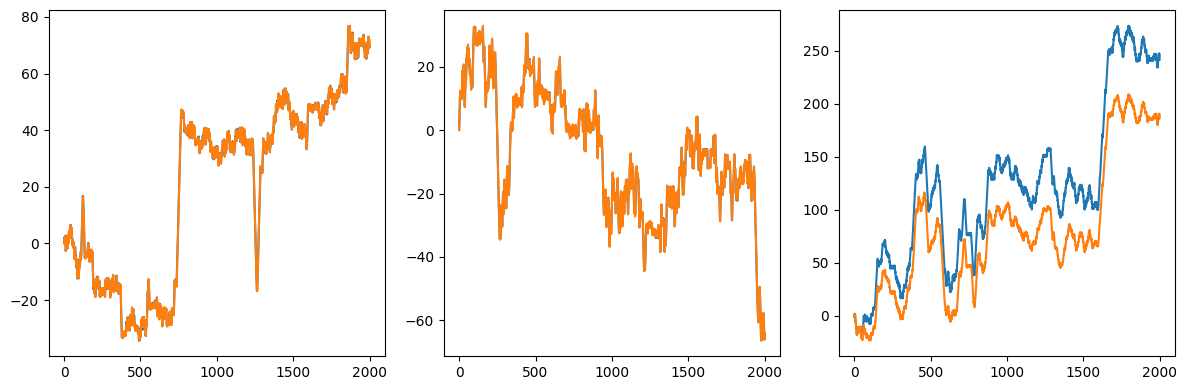

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    ax = axs[i]
    ax.plot(tls_, trues[:, i])
    ax.plot(tls_, assimilateds[:, i])

fig.tight_layout()
plt.show()